In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from pylab import rcParams
from sklearn.metrics import mean_absolute_error,mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols,adfuller
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg,AutoRegResults,ar_select_order
from time import time
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARIMA

warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('../input/data-analytics-ue20cs312/train.csv')
df

,Date,Open,High,Low,Close,Volume
0,2016-01-04,1099.59,1110.75,1093.85,1109.64,66545000
1,2016-01-05,1117.47,1130.57,1112.75,1125.85,41227200
2,2016-01-06,1116.63,1138.68,1116.10,1133.04,42316800
3,2016-01-07,1122.00,1149.76,1117.56,1143.37,64899600
4,2016-01-08,1145.64,1149.96,1120.93,1122.88,52138900
...,...,...,...,...,...,...
1650,2022-07-25,2412.25,2429.44,2387.41,2402.95,29106300
1651,2022-07-26,2289.29,2307.08,2255.66,2280.27,48503400
1652,2022-07-27,2309.14,2404.25,2296.82,2395.54,43790900
1653,2022-07-28,2385.58,2443.26,2377.34,2434.89,25807000


In [3]:
#setting index
df.set_index("Date",inplace=True)
df.index=pd.to_datetime(df.index)


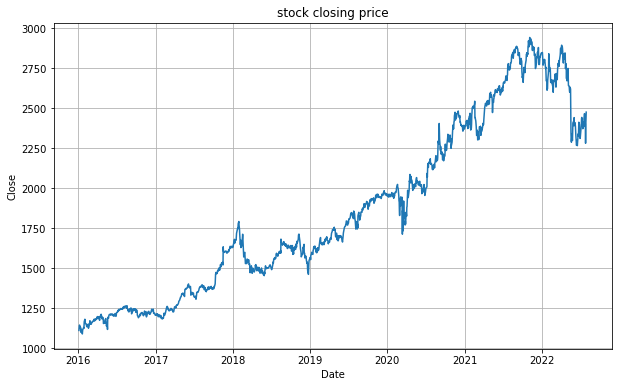

In [4]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(df['Close'])
plt.title('stock closing price')
plt.show()


<AxesSubplot:ylabel='Density'>

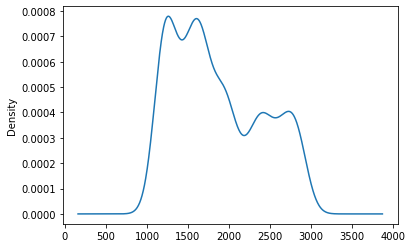

In [5]:
#Distribution of the dataset( probability distribution)
df['Close'].plot(kind='kde')

In [6]:
df.isna().sum().sum()

0

<AxesSubplot:xlabel='Date'>

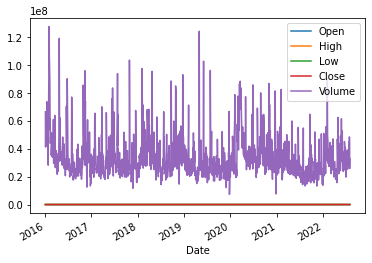

In [7]:
#drop null values
df.dropna(inplace=True)
#plot the series
df.plot()

From the above graph, we can see that the closing prices have trend in them so data can't be stationary

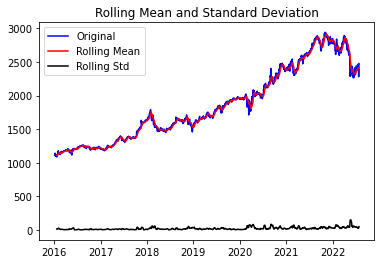

Results of dickey fuller test
Test Statistics                  -0.961490
p-value                           0.767050
No. of lags used                  9.000000
Number of observations used    1645.000000
critical value (1%)              -3.434331
critical value (5%)              -2.863299
critical value (10%)             -2.567706
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

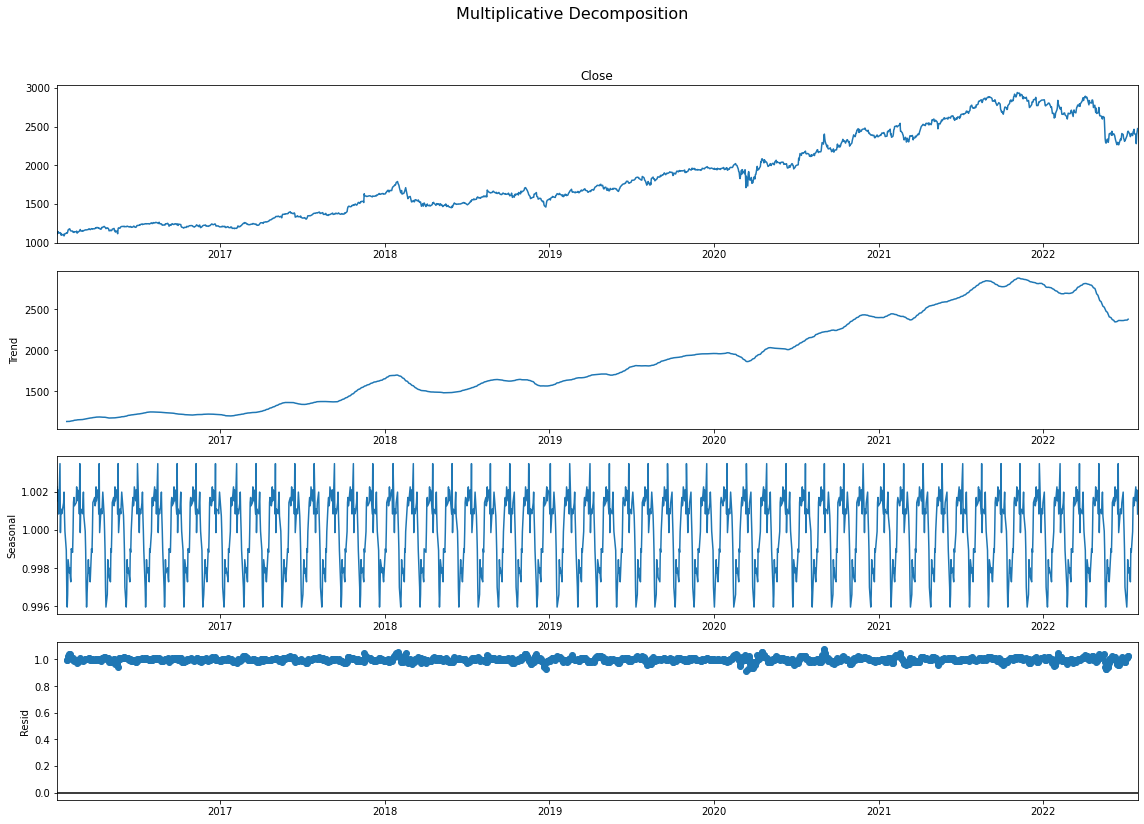

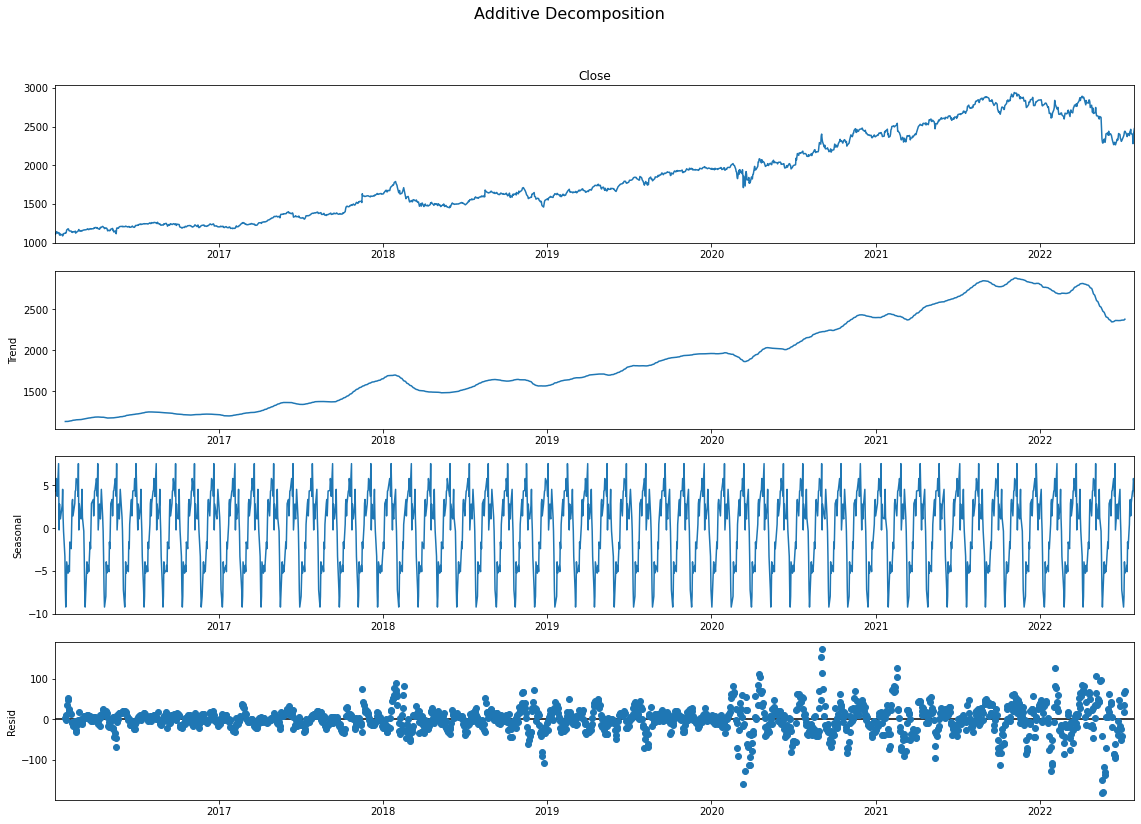

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['Close'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

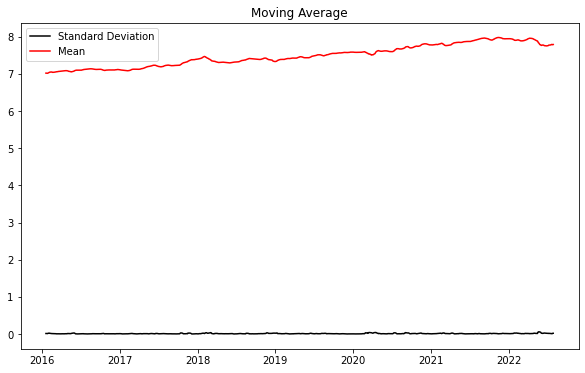

In [10]:
#if not stationary then eliminate trend
#Eliminate trend
df_close = df['Close']
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

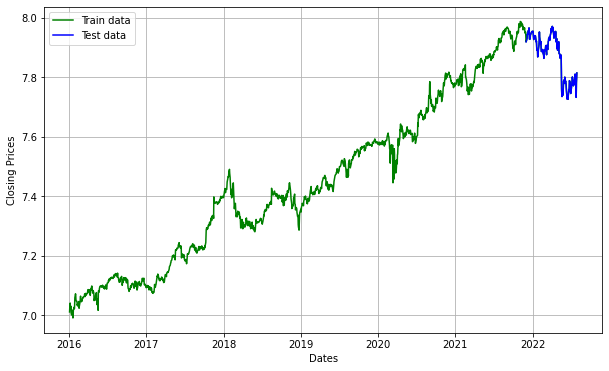

In [11]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [12]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.4 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9244.926, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9284.296, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9282.170, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9242.305, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9282.588, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9282.561, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9280.527, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9279.786, Time=0.25 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.692 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1486
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4645.148
Date:                Sun, 16 Oct 2022   AIC                          -9284.296
Time:                       

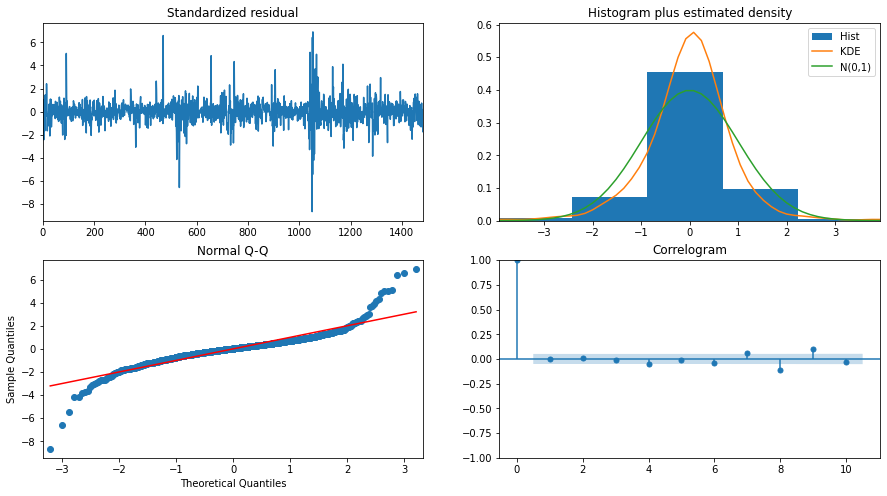

In [13]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [14]:
#Modeling
# Build Model
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,0))
  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1486
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4641.893
Date:                Sun, 16 Oct 2022   AIC                          -9279.786
Time:                        16:16:34   BIC                          -9269.179
Sample:                             0   HQIC                         -9275.832
                               - 1486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1620      0.010    -15.885      0.000      -0.182      -0.142
sigma2         0.0001   1.64e-06     68.864      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [15]:
forecast = fitted.forecast(15, alpha=0.05)
print(forecast.values)

[7.93569111 7.93520461 7.93528344 7.93527067 7.93527274 7.9352724
 7.93527246 7.93527245 7.93527245 7.93527245 7.93527245 7.93527245
 7.93527245 7.93527245 7.93527245]


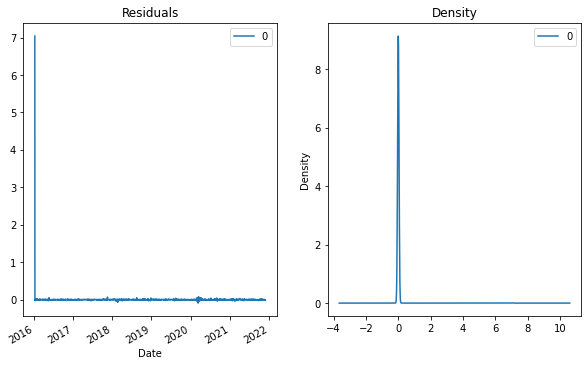

In [16]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [17]:
# Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict
fitted.predict(dynamic=False)


Date
2016-01-07    0.000000
2016-01-08    7.041735
2016-01-11    7.026582
2016-01-12    7.029638
2016-01-13    7.028406
                ...   
2021-11-23    7.961517
2021-11-24    7.963095
2021-11-26    7.965303
2021-11-29    7.950702
2021-11-30    7.950665
Name: predicted_mean, Length: 1486, dtype: float64

In [18]:
train_dataset = pd.read_csv('../input/data-analytics-ue20cs312/train.csv')
test_dataset = pd.read_csv('../input/data-analytics-ue20cs312/test.csv')
submission_dataset = pd.read_csv('../input/data-analytics-ue20cs312/sample_submission.csv')
X_train = train_dataset[['Open','High','Low','Volume']]
y_train= train_dataset['Close']
X_test= test_dataset[['Open','High','Low','Volume']]

In [19]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = regressor.predict(X_test)

In [21]:
print(y_pred)

[2485.54736286 2473.79713315 2481.06370484 2437.91176866 2434.0979842
 2459.61023538 2440.52013793 2483.31025528 2479.37166745 2520.6168203
 2535.46147291 2601.47026751 2610.44407476 2582.62518042 2539.1894966
 2492.83753483 2482.30313303 2483.97032581 2514.85572448 2447.04922701
 2436.55911464 2415.19715209 2422.84290302 2442.93317432 2422.91399482
 2391.01482519 2451.4505561  2454.04517209 2482.33942814 2490.64324387
 2424.83022567 2408.85167559 2386.26976777 2374.00937757 2386.26994579]


In [22]:
submission_dataset['Close']= y_pred
print(submission_dataset)

          Date        Close
0   2022-08-01  2485.547363
1   2022-08-02  2473.797133
2   2022-08-03  2481.063705
3   2022-08-04  2437.911769
4   2022-08-05  2434.097984
5   2022-08-08  2459.610235
6   2022-08-09  2440.520138
7   2022-08-10  2483.310255
8   2022-08-11  2479.371667
9   2022-08-12  2520.616820
10  2022-08-15  2535.461473
11  2022-08-16  2601.470268
12  2022-08-17  2610.444075
13  2022-08-18  2582.625180
14  2022-08-19  2539.189497
15  2022-08-22  2492.837535
16  2022-08-23  2482.303133
17  2022-08-24  2483.970326
18  2022-08-25  2514.855724
19  2022-08-26  2447.049227
20  2022-08-29  2436.559115
21  2022-08-30  2415.197152
22  2022-08-31  2422.842903
23  2022-09-01  2442.933174
24  2022-09-02  2422.913995
25  2022-09-06  2391.014825
26  2022-09-07  2451.450556
27  2022-09-08  2454.045172
28  2022-09-09  2482.339428
29  2022-09-12  2490.643244
30  2022-09-13  2424.830226
31  2022-09-14  2408.851676
32  2022-09-15  2386.269768
33  2022-09-16  2374.009378
34  2022-09-19  2386

In [23]:
submission_dataset.to_csv('submission.csv',index = False)